# Ensemble Learning and Random Forests

* if we aggregate the predictions of a group of predictors (such as classifiers or regressors),
we will often get better predictions than with the best individual predictor. 
* A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning.
* Ensemble Learning algorithm is called an Ensemble method

* we can train a group of Decision Tree classifiers, each on a different random subset of the training set.
* To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a **Random Forest**.

### Introduction to Python Ensembles

#### Predicting Republican and Democratic donations
* To illustrate how **ensembles work**, we'll use a data set on U.S. political contributions. 
* The original data set was prepared by Ben Wieder at FiveThirtyEight, who dug around the U.S. government's political contribution registry and found that when scientists donate to politician, it's usually to Democrats.

### About features
##### Donor
* entity_tp   : tells us whether the prediction was made by an individual(as opposed to an organization)
* state       : is the state of residence of the contributor.
* classification : is the scientific field they work in(created by team at 538)

##### Transaction
* rtp_tp: htis feature identifies contributions made during campaigns
* transaction_tp: the form of contribution made: for instance from the candidate him/herself, or from an individual to a political committee
* cycle: the year the contribution was made
* transaction_amt: the nominal USD amount of the donation

##### Recipient
* candy_pty_affiliation: is the candidate's self-reported' party affiliation. this is the variable we want to predict
* cand_office_st: is the state the candidate is active in
* cand_office: is the office they are either occupying or candidating for
* cand_status: tells us whether they are candidating for office or already occupying it.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
SEED = 222
np.random.seed(SEED)

In [2]:
# import data
df = pd.read_csv('input.csv')
df.head()

cand_pty_affiliation cand_office_st cand_office cand_status rpt_tp  \
0                  REP             US           P           C     Q3   
1                  DEM             US           P           C     M5   
2                  DEM             US           P           C     M3   
3                  DEM             US           P           C     Q2   
4                  REP             US           P           C    12G   

  transaction_tp entity_tp state classification   cycle  transaction_amt  
0             15       IND    NY       Engineer  2016.0            500.0  
1            15E       IND    OR      Math-Stat  2016.0             50.0  
2             15       IND    TX      Scientist  2008.0            250.0  
3            15E       IND    IN      Math-Stat  2016.0            250.0  
4             15       IND    MA       Engineer  2016.0            184.0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
cand_pty_affiliation    100000 non-null object
cand_office_st          100000 non-null object
cand_office             100000 non-null object
cand_status             100000 non-null object
rpt_tp                  100000 non-null object
transaction_tp          100000 non-null object
entity_tp               100000 non-null object
state                   100000 non-null object
classification          100000 non-null object
cycle                   100000 non-null float64
transaction_amt         100000 non-null float64
dtypes: float64(2), object(9)
memory usage: 8.4+ MB


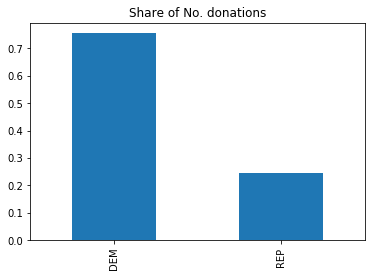

In [4]:
x = df.cand_pty_affiliation.value_counts(normalize=True).plot(
    kind="bar", title="Share of No. donations")

**conclusion:** This plot shows 75% of all contributions are made to democrats

### Training and test set

In [5]:
def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

In [6]:
xtrain, xtest, ytrain, ytest = get_train_test()

### Understanding ensembles by combining decision trees

In [7]:
# function to visualize our decision rules:
import pydotplus 
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False, 
        out_file=None, 
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

### fit a decision tree

Decision tree ROC-AUC score: 0.751


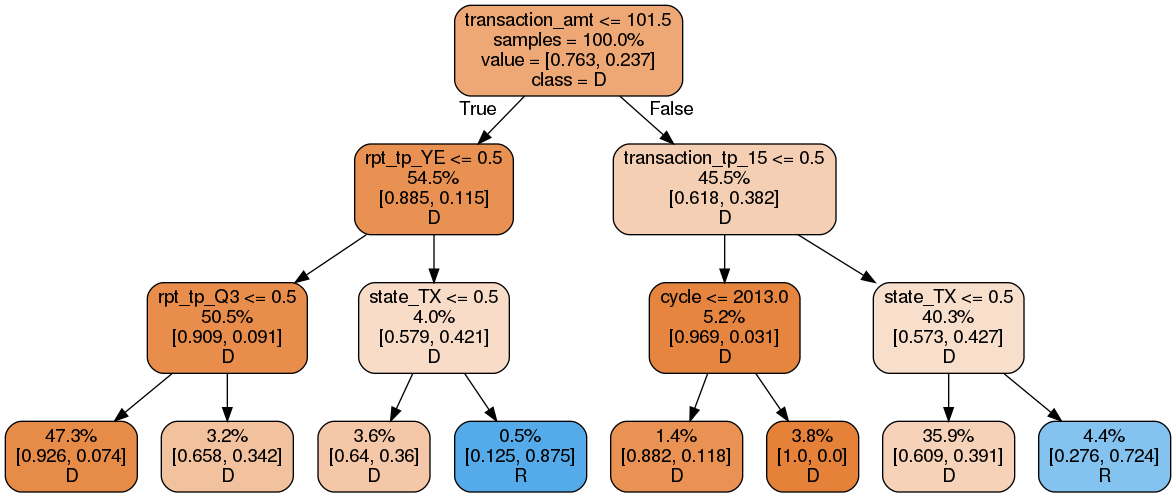

In [68]:
t1 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

*  5% of all donations are predicted to go to Republicans–far short of the 25% we would expect. 
* A closer look tells us that the decision tree uses some dubious splitting rules. 
     * A whopping 47.3% of all observations end up in the left-most leaf, while another 35.9% end up in the leaf second to the right. 
     * The vast majority of leaves are therefore irrelevant. Making the model deeper just causes it to overfit.

** Fixing depth, a decision tree can be made more complex by increasing "width", i.e, creating several decision trees and combining them. In other words, an ensemble of decision trees.**

* if we may force a decision tree to investigate other patterns than those in the above tree. 
    * The simplest solution is to remove features that appear early in the tree. 
    * Suppose for instance that we remove the transaction amount feature (transaction_amt), the root of the tree. 

**Our new decision tree would look like this:**

Decision tree ROC-AUC score: 0.740


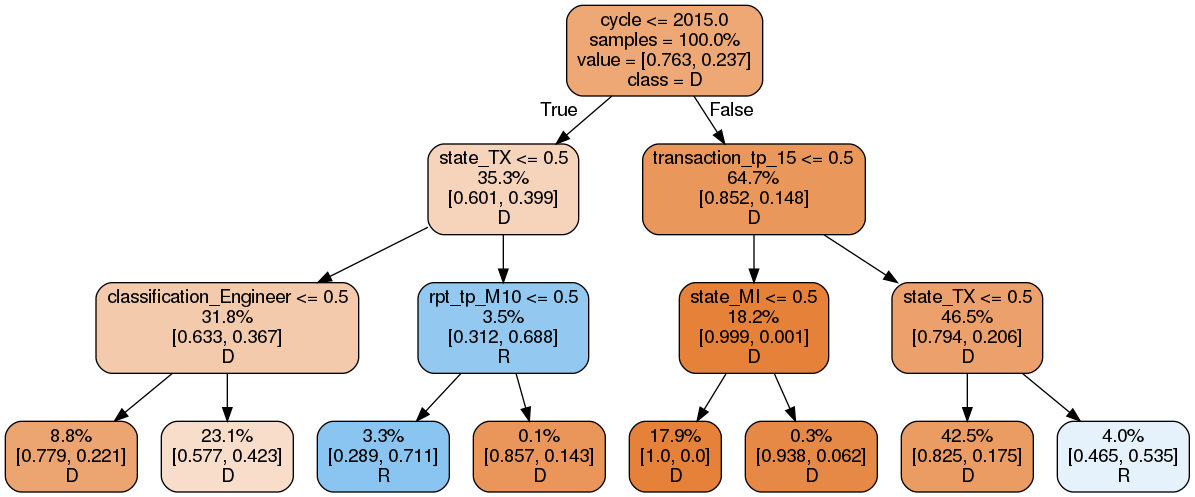

In [10]:
drop = ["transaction_amt"]

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

#### Ensemble of decision trees

In [70]:
p1 = t1.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.783


**conclusion:** 
* observing ROC-AUC scores of
    * decision tree1 = 0.75
    * decision tree2 = 0.74
    * ensemble model = 0.783
* Ensemble model did better classification than decision tree.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.844


# comparing all classifiers preformance with ensamble 

In [13]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [14]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... done
knn... done
naive bayes... done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
svm                       : 0.850
knn                       : 0.779
naive bayes               : 0.803
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.857
Done.



In [15]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.883


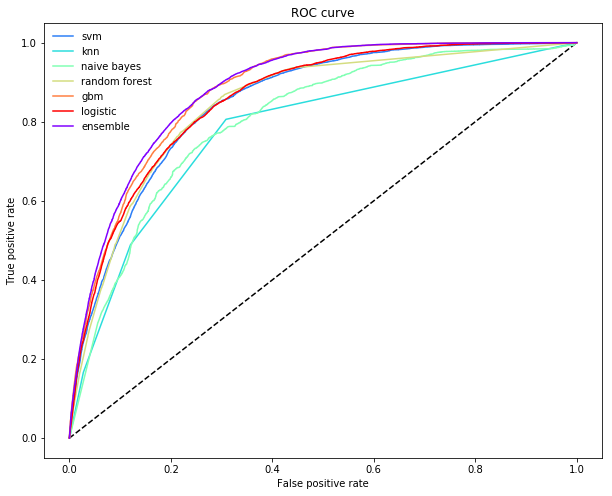

In [71]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

**conclusions:**
ensemble model classified more accuratly then other individual classifiers.

# Using VotingClassifier

* A very simple way to create an even better classifier is to aggregate the predictions of each
classifier and predict the class that gets the most votes. This majority-vote classifier is
called a **hard voting classifier**.

* If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba()
method), then you can tell Scikit-Learn to predict the class with the highest class
probability, averaged over all the individual classifiers. This is called **soft voting**.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### When voting = 'hard'

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [19]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


### When voting = 'soft'

In [20]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [21]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


**conclusion:**
* Ensemble modle with voting parameter = **soft** classified classes more accurate than voting parameter = **hard**.  

# Bagging ensembles

* One way to get a diverse set of classifiers is to use very different training algorithms, as
just discussed.
* Another approach is to use the same training algorithm for every predictor,
but to train them on different random subsets of the training set. 
   * When sampling is performed with replacement, this method is called bagging 1 (short for bootstrap
aggregating).
   * When sampling is performed without replacement, it is called pasting.

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [23]:
accuracy_score(y_test, y_pred)

0.90400000000000003

In [24]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.85599999999999998

In [25]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c= y, alpha=1)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

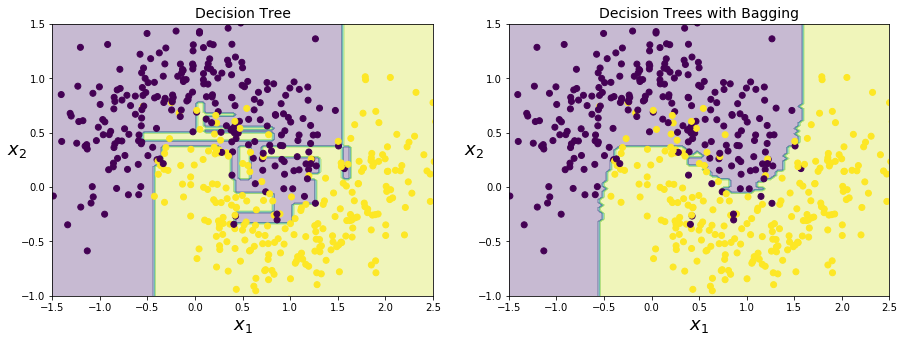

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
x= plt.title("Decision Trees with Bagging", fontsize=14)

# Random Forests

In [27]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [28]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [29]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [30]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.97599999999999998

# Out-of-Bag evaluation

* By default a BaggingClassifier samples m training instances with replacement ( bootstrap=True ), where m is the size of the training set. 
* This means that only about 63% of the training instances are sampled on average for each
predictor. 
* The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances.

* Since a predictor never sees the oob instances during training, it can be evaluated on these
instances, without the need for a separate validation set or cross-validation.
* You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.
* you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training.

In [31]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90133333333333332

In [32]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91200000000000003

# Feature importance

In [33]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [38]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

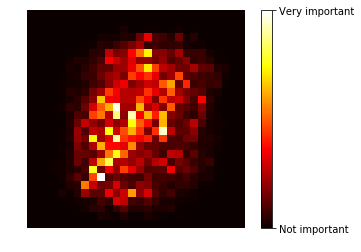

In [42]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
x = cbar.ax.set_yticklabels(['Not important', 'Very important'])

### Random Patches and Random Subspaces

* The BaggingClassifier class supports sampling the features as well.
* This is controlled by two hyperparameters: max_features and bootstrap_features.
* They work the same way as max_samples and bootstrap , but for feature sampling instead of instance sampling.
* Sampling both training instance and features is called random patches

# Booster

* Boosting (originally called hypothesis boosting) refers to any Ensemble method that can
combine several weak learners into a strong learner.
* The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

### AdaBoost

In [44]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

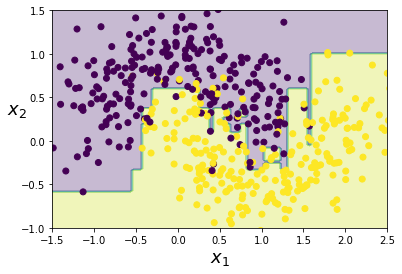

In [45]:
plot_decision_boundary(ada_clf, X, y)

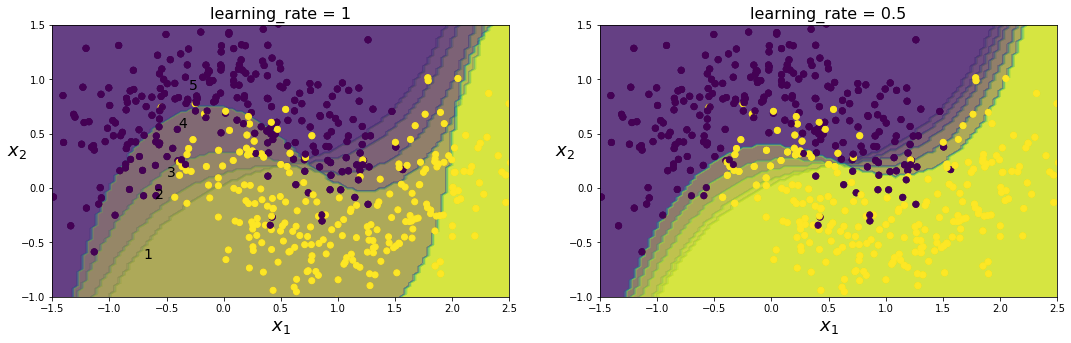

In [52]:
m = len(X_train)

plt.figure(figsize=(18, 5))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
x=plt.text(-0.3,  0.90, "5", fontsize=14)

# Gradient Boosting

* Another very popular Boosting algorithm is Gradient Boosting.
* Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.

In [59]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [60]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [61]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [62]:
X_new = np.array([[0.8]])

In [63]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [64]:
y_pred

array([ 0.75026781])

In [65]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)


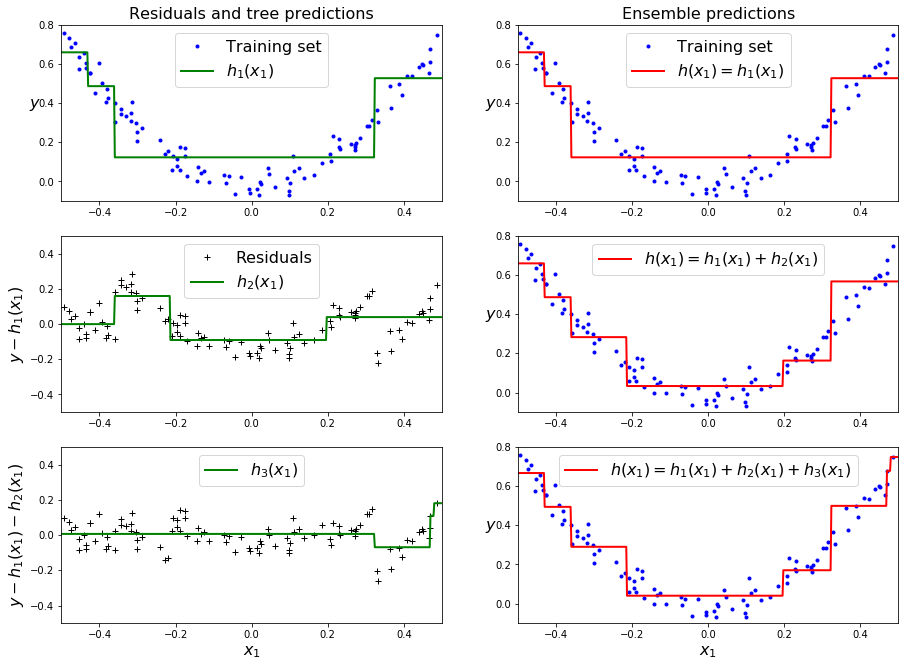

In [83]:
plt.figure(figsize=(15,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
x= plt.ylabel("$y$", fontsize=16, rotation=0)